In [4]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, QuantileTransformer
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
from scipy.stats import zscore
import random
import pymysql

In [5]:
host = "localhost"
port= 3306
database = 'burger_sales'
user = 'root'
password = 'ranjeetjb'

conn = pymysql.connect(host=host,
                      user=user,
                      password=password,
                      database=database,
                      port=port)
query = "SELECT * FROM burger_sales_data;"
df=pd.read_sql(query, conn)
conn.close()
print(df.head())

C:\Users\Ranjeet Kumar\AppData\Local\Temp\ipykernel_16552\3162228948.py:13: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df=pd.read_sql(query, conn)


         Date Region  Temperature  Humidity       Wind  Visibility  \
0  15-09-2020   Reg1    10.248814  0.779164  11.509130   14.503403   
1  14-09-2020   Reg1    10.337595  0.908549   7.432656    2.232960   
2  13-09-2020   Reg1    20.763686  0.505324   7.788249    4.779211   
3  12-09-2020   Reg1    21.500892  0.758557   3.767432    9.904534   
4  11-09-2020   Reg1    21.774269  0.398296  20.705369   15.224605   

      Pressure    Sales  
0  1017.293917   991.60  
1  1019.452636  1858.59  
2  1022.677119     3.99  
3  1009.341357  3090.78  
4  1015.713234   990.99  


In [6]:
# Data Preprocessing
def preprocess_data(df):
    """Handle missing values, outliers, and feature engineering."""
    # 1. Handle Missing Values
    imputer = SimpleImputer(strategy='median')
    df[['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure', 'Sales']] = imputer.fit_transform(df[['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure', 'Sales']])

    # 2. Handle Outliers using Z-score method
    z_scores = np.abs(zscore(df[['Temperature', 'Humidity', 'Wind', 'Visibility', 'Pressure', 'Sales']]))
    threshold = 3
    df_no_outliers = df[(z_scores < threshold).all(axis=1)]

    # 3. Feature Engineering: Lag Features and Rolling Mean
    df_no_outliers['Sales_lag_1'] = df_no_outliers['Sales'].shift(1)
    df_no_outliers['Sales_lag_7'] = df_no_outliers['Sales'].shift(7)
    df_no_outliers['Sales_rolling_mean_7'] = df_no_outliers['Sales'].rolling(window=7).mean()
    df_no_outliers.dropna(inplace=True)  # Drop NaN values created by lag features and rolling mean

    return df_no_outliers

# Prepare Data for LSTM
def prepare_data(df, window_size=30):
    """Prepare time series data for LSTM."""
    sales = df['Sales'].values.reshape(-1, 1)
    scaler = MinMaxScaler(feature_range=(0, 1))  # Scale data to range (0, 1)
    scaled_sales = scaler.fit_transform(sales)

    X, y = [], []
    for i in range(window_size, len(scaled_sales)):
        X.append(scaled_sales[i-window_size:i, 0])
        y.append(scaled_sales[i, 0])

    X, y = np.array(X), np.array(y)
    X = np.reshape(X, (X.shape[0], X.shape[1], 1))  # 3D shape for LSTM (samples, timesteps, features)

    return X, y, scaler

In [11]:
# Function to build LSTM model with hyperparameters
def build_model(units1, units2, dropout_rate, learning_rate):
    """Build and compile the LSTM model."""
    model = Sequential()
    model.add(LSTM(units=units1, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])))
    model.add(Dropout(dropout_rate))
    model.add(LSTM(units=units2, return_sequences=False))
    model.add(Dropout(dropout_rate))
    model.add(Dense(1))  # Single output node for regression
    model.compile(optimizer=Adam(learning_rate=learning_rate), loss='mean_squared_error', metrics=['mae'])
    return model

# Random Search for Hyperparameters
def random_search_hyperparameters(X_train, y_train, X_val, y_val, n_iter=20):
    """Randomly search for the best hyperparameters for LSTM."""
    best_score = float('inf')
    best_params = None
    best_model = None

    for i in range(n_iter):
        print(f"Random Search Iteration: {i+1}/{n_iter}")

        # Randomly select hyperparameters
        units1 = random.choice([32, 64, 128, 256])
        units2 = random.choice([32, 64, 128, 256])
        dropout_rate = random.uniform(0.1, 0.5)
        learning_rate = 10 ** random.uniform(-4, -2)

        print(f"Testing Hyperparameters: units1={units1}, units2={units2}, dropout_rate={dropout_rate:.4f}, learning_rate={learning_rate:.6f}")

        # Build and train the model
        model = build_model(units1, units2, dropout_rate, learning_rate)
        early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

        history = model.fit(X_train, y_train, epochs=30, batch_size=32,
                            validation_data=(X_val, y_val),
                            callbacks=[early_stopping],
                            verbose=1)

        val_loss = min(history.history['val_loss'])
        print(f"Validation Loss: {val_loss}")

        if val_loss < best_score:
            best_score = val_loss
            best_params = {'units1': units1, 'units2': units2, 'dropout_rate': dropout_rate, 'learning_rate': learning_rate}
            best_model = model

    return best_model, best_params, best_score

In [12]:
df = preprocess_data(df)
df.head()

C:\Users\Ranjeet Kumar\AppData\Local\Temp\ipykernel_16552\2885962469.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Sales_lag_1'] = df_no_outliers['Sales'].shift(1)
C:\Users\Ranjeet Kumar\AppData\Local\Temp\ipykernel_16552\2885962469.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_no_outliers['Sales_lag_7'] = df_no_outliers['Sales'].shift(7)
C:\Users\Ranjeet Kumar\AppData\Local\Temp\ipykernel_16552\2885962469.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy

,Date,Region,Temperature,Humidity,Wind,Visibility,Pressure,Sales,Sales_lag_1,Sales_lag_7,Sales_rolling_mean_7
14,01-09-2020,Reg1,26.804288,0.497145,16.015887,7.657317,1014.169287,1298.16,951.63,1584.29,1405.400000
15,31-08-2020,Reg1,26.313257,0.430327,18.464231,10.129818,1014.248745,1106.16,1298.16,107.60,1548.051429
16,30-08-2020,Reg1,25.963561,0.416924,22.598363,14.375993,1013.505181,1496.54,1106.16,3108.91,1317.712857
17,29-08-2020,Reg1,24.100843,0.418284,15.562336,4.660738,1021.252671,170.41,1496.54,960.01,1204.912857
18,28-08-2020,Reg1,25.263122,0.649281,10.381452,8.382196,1011.491033,2889.31,170.41,415.47,1558.318571


In [13]:
# Prepare the data for LSTM
X, y, scaler = prepare_data(df, window_size=30)

# Split data into train and validation sets
train_size = int(len(X) * 0.8)
X_train, X_val = X[:train_size], X[train_size:]
y_train, y_val = y[:train_size], y[train_size:]

# Hyperparameter search
best_model, best_params, best_score = random_search_hyperparameters(X_train, y_train, X_val, y_val, n_iter=20)
print(f"Best Hyperparameters: {best_params}")
print(f"Best Validation Loss: {best_score}")

# Evaluate the model
y_pred = best_model.predict(X_val)

Random Search Iteration: 1/20
Testing Hyperparameters: units1=256, units2=128, dropout_rate=0.2651, learning_rate=0.002578
Epoch 1/30


C:\Users\Ranjeet Kumar\anaconda3\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


595/595 ━━━━━━━━━━━━━━━━━━━━ 30s 46ms/step - loss: 0.0927 - mae: 0.2614 - val_loss: 0.0719 - val_mae: 0.2299
Epoch 2/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 33s 55ms/step - loss: 0.0737 - mae: 0.2297 - val_loss: 0.0715 - val_mae: 0.2235
Epoch 3/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 37s 49ms/step - loss: 0.0721 - mae: 0.2258 - val_loss: 0.0714 - val_mae: 0.2235
Epoch 4/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 30s 50ms/step - loss: 0.0728 - mae: 0.2273 - val_loss: 0.0735 - val_mae: 0.2277
Epoch 5/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 26s 44ms/step - loss: 0.0711 - mae: 0.2242 - val_loss: 0.0699 - val_mae: 0.2240
Epoch 6/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0704 - mae: 0.2233 - val_loss: 0.0698 - val_mae: 0.2241
Epoch 7/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0702 - mae: 0.2232 - val_loss: 0.0696 - val_mae: 0.2183
Epoch 8/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 21s 35ms/step - loss: 0.0694 - mae: 0.2209 - val_loss: 0.0689 - val_mae: 0.2181
Epoch 9/30
595/595 ━━━━━━━━━━━━━━━━━━━━ 20s 34ms/st

Best Hyperparameters: {'units1': 64, 'units2': 128, 'dropout_rate': 0.273557889236971, 'learning_rate': 0.007731488557188124}
Root Mean Squared Error (RMSE): 0.24673963338135996
Mean Absolute Error (MAE): 0.20136635468287267
R-Squared (R2): 0.34534184802850887


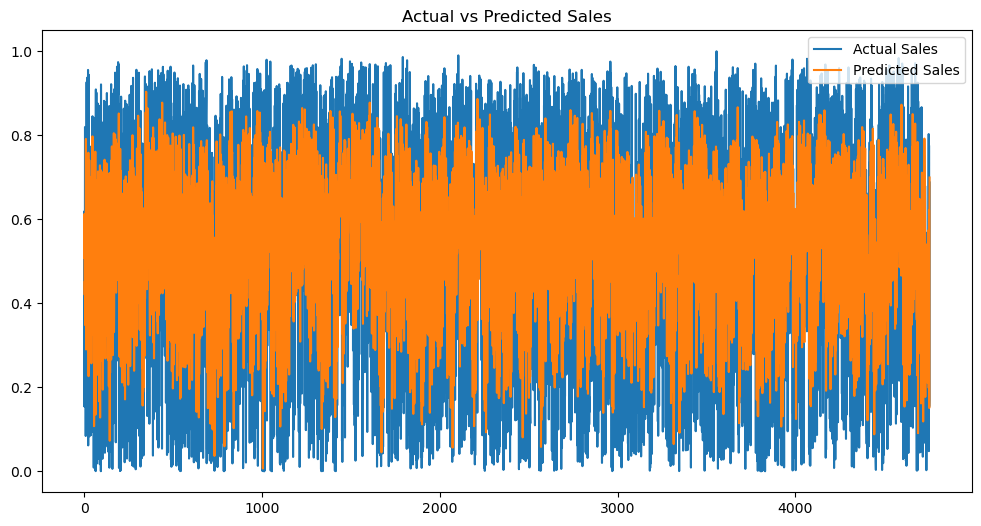

In [14]:
# Calculate evaluation metrics
rmse = np.sqrt(mean_squared_error(y_val, y_pred))
mae = mean_absolute_error(y_val, y_pred)
r2 = r2_score(y_val, y_pred)

print(f"Best Hyperparameters: {best_params}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Mean Absolute Error (MAE): {mae}")
print(f"R-Squared (R2): {r2}")

# Plot actual vs predicted sales
plt.figure(figsize=(12, 6))
plt.plot(y_val, label='Actual Sales')
plt.plot(y_pred, label='Predicted Sales')
plt.legend()
plt.title('Actual vs Predicted Sales')
plt.show()

In [15]:
best_model.save('sales_forecasting_lstm_model.h5')

In [16]:
from tensorflow.keras.models import load_model

loaded_model = load_model('sales_forecasting_lstm_model.h5')

In [17]:
best_model.save('sales_forecasting_lstm_model.keras')

In [18]:
from tensorflow.keras.models import load_model

loaded_model = load_model('sales_forecasting_lstm_model.keras')

C:\Users\Ranjeet Kumar\anaconda3\lib\site-packages\keras\src\saving\saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 10 variables whereas the saved optimizer has 18 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [19]:
# Assume X_val is the validation data you want to predict on
predictions = loaded_model.predict(X_val)

# Print first 5 predictions
print(predictions[:5])

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 15ms/step
[[0.58980507]
 [0.50730735]
 [0.61284834]
 [0.42031187]
 [0.45260316]]


In [20]:
# Evaluate the model on the validation set
loss, mae = loaded_model.evaluate(X_val, y_val)
print(f"Loss: {loss}, Mean Absolute Error (MAE): {mae}")

149/149 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0631 - mae: 0.2059
Loss: 0.06088044494390488, Mean Absolute Error (MAE): 0.2013663500547409
